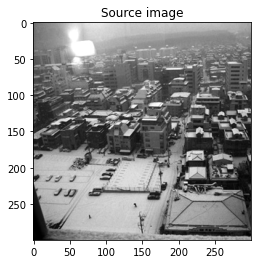

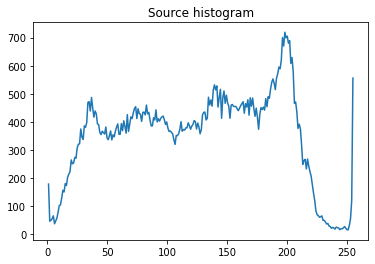

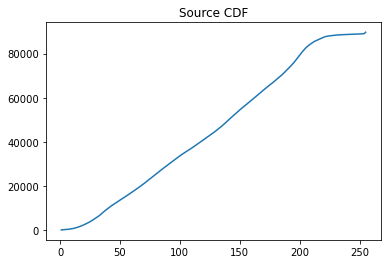

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform

X = None
Y = None #basic init of target_im crop size

def adap_hist_matching(source_im, target_im, D):
    
    # Cut the images
    source_cropped = cut_image(source_im, D, D)
    if(X == None or Y == None):
        target_cropped = target_im
    else:
        target_cropped = cut_image(target_im, X, Y)
    
    #calculate a source pixel count
    width_s = source_cropped.shape[0]
    height_s = source_cropped.shape[1]
    pixels_s = width_s * height_s
    
    #calculate a target pixel count
    width_t = target_cropped.shape[0]
    height_t = target_cropped.shape[1]
    pixels_t = width_t * height_t
    
    #get the normed histograms
    target_hist, tarbet_bin = get_hist(target_cropped)
    source_hist, source_bin = get_hist(source_cropped)
    
    #find the cumulative distribution functions 
    target_cdf = CDF(target_hist, tarbet_bin)
    source_cdf = CDF(source_hist, source_bin)
    
    #get probabilities of two cdfs
    target_cdf_prob = target_cdf / pixels_t
    source_cdf_prob = source_cdf / pixels_s
    
    #calculate a new pixel value by a probabilitie
    K = 256
    new_values = np.zeros((K))
    for a in np.arange(K):
        j = 255
        while True:
            new_values[a] = j
            j = j - 1
            if j < 0 or source_cdf_prob[a] > target_cdf_prob[j]:
                break
                
    #apply new value for each source pixel
    for i in np.arange(height_s):
        for j in np.arange(width_s):
            a = source_cropped.item(i,j)
            
            b = new_values[a]
            
            source_cropped.itemset((i,j), b)
    
    
    return source_cropped

def load_image(path):
    return io.imread(path) if path is not None else None

def cut_image(source, x, y):
    return source[0:y, 0:x]

def get_hist(image):
    return np.histogram(image, bins = 256)

def CDF(hist, b):
    dx = b[1] - b[0]
    return np.cumsum(hist) * dx
    
D = 300
target = load_image("ref.jpg")
source = load_image("adj.jpg")
out_im = adap_hist_matching(source.copy(), target.copy(), D)
target = cut_image(target, D, D)
source = cut_image(source, D, D)
hist_t, b_t = get_hist(target)
hist_s, b_s = get_hist(source)
hist_o, b_o = get_hist(out_im)
cdf_t = CDF(hist_t, b_t)
cdf_s = CDF(hist_s, b_s)
cdf_o = CDF(hist_o, b_o)
plt.figure()
plt.title("Source image")
plt.imshow(source, cmap='gray')
plt.figure()
plt.title("Source histogram")
plt.plot(b_s[1:], hist_s)
plt.figure()
plt.title("Source CDF")
plt.plot(b_s[1:], cdf_s)

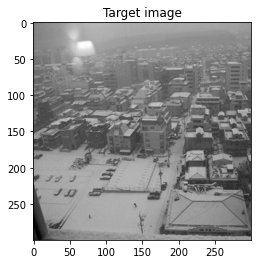

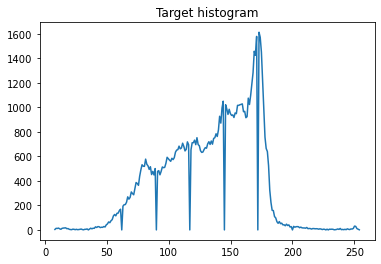

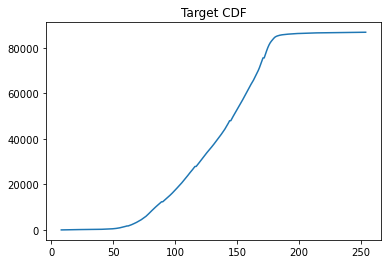

In [142]:
plt.figure()
plt.title("Target image")
plt.imshow(target, cmap='gray')
plt.figure()
plt.title("Target histogram")
plt.plot(b_t[1:], hist_t)
plt.figure()
plt.title("Target CDF")
plt.plot(b_t[1:], cdf_t)

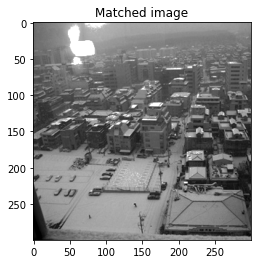

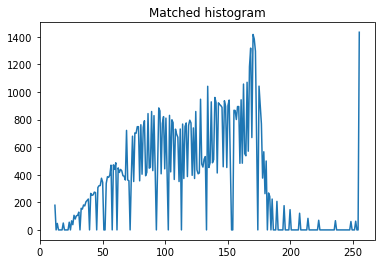

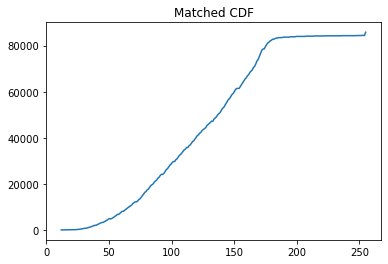

In [141]:
plt.figure()
plt.title("Matched image")
plt.imshow(out_im, cmap='gray')
plt.figure()
plt.title("Matched histogram")
plt.plot(b_o[1:], hist_o)
plt.figure()
plt.title("Matched CDF")
plt.plot(b_o[1:], cdf_o)